### Model parameter table

- Compiling model parameters from various different fits into a table
- Relies on processed data generated using _00_ProcessData.ipynb_

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src import EnergiesConfidenceIntervalPaired, nb_setup

%matplotlib inline

nb_setup()
os.makedirs("Figs", exist_ok=True)

%matplotlib inline

### Import data

In [2]:
df_main = pd.read_csv("df_main.csv")
df_s1 = pd.read_csv("df_s1.csv")
df_s2 = pd.read_csv("df_s2.csv")

# Association constants expressed in log10 form
Ka_wt = 6.446  # <- AUC measurement
Ka_mut = 6.446  # <- initial guess
Km = 2.5  # <- initial guass

### Analysis with shared Km

In [3]:
analysis1 = EnergiesConfidenceIntervalPaired(
    df_main, log=True, p0=(Ka_wt, Ka_mut, Km), fix_wt=True, fix_mut=False, fit_D=False
)
analysis2 = EnergiesConfidenceIntervalPaired(
    df_s1, log=True, p0=(Ka_wt, Ka_mut, Km), fix_wt=True, fix_mut=False, fit_D=False
)
analysis3 = EnergiesConfidenceIntervalPaired(
    df_s2, log=True, p0=(Ka_wt, Ka_mut, Km), fix_wt=True, fix_mut=False, fit_D=False
)
analysis4 = EnergiesConfidenceIntervalPaired(
    df_main, log=True, p0=(Ka_wt, Ka_mut, Km), fix_wt=False, fix_mut=False, fit_D=False
)
analysis5 = EnergiesConfidenceIntervalPaired(
    df_s1, log=True, p0=(Ka_wt, Ka_mut, Km), fix_wt=False, fix_mut=False, fit_D=False
)
analysis6 = EnergiesConfidenceIntervalPaired(
    df_s2, log=True, p0=(Ka_wt, Ka_mut, Km), fix_wt=False, fix_mut=False, fit_D=False
)

### Table

In [4]:
def create_row(analysis, D, figure):
    # Extract data
    fix_wt = analysis.fix_wt
    ka_full_wt = analysis.ka_full[0]
    ka_full_L109R = analysis.ka_full[1]
    kas_wt = analysis.kas[0]
    kas_L109R = analysis.kas[1]
    ka_full_fold = 10 ** (ka_full_wt - ka_full_L109R)
    kas_fold = 10 ** (kas_wt - kas_L109R)
    km_full = analysis.km_full
    kms = analysis.kms

    # D
    row = {"a (nm)": str(D)}

    # ka wt fixed?
    row["$K\mathrm{_D^{dim}}$ WT fixed?"] = "Yes" if fix_wt else "No"

    # kD_dim wt
    a = 10 ** (-ka_full_wt + 6)
    [low, high] = 10 ** (np.percentile(-kas_wt + 6, [2.5, 97.5]))
    row["$K\mathrm{_D^{dim}}$ WT (µM)"] = (
        f"{a:.3f} [{low:.3f}, {high:.3f}]" if not fix_wt else f"{a:.3f}"
    )

    # kD_dim mut
    a = 10 ** (-ka_full_L109R + 6)
    [low, high] = 10 ** (np.percentile(-kas_L109R + 6, [2.5, 97.5]))
    row["$K\mathrm{_D^{dim}}$ L109R (µM)"] = f"{a:.3f} [{low:.3f}, {high:.3f}]"

    # kD fold
    a = ka_full_fold
    [low, high] = np.percentile(kas_fold, [2.5, 97.5])
    row["$K\mathrm{_D^{dim}}$ fold difference"] = f"{a:.2f} [{low:.2f}, {high:.2f}]"

    # kD_mem
    a = -km_full
    [low, high] = np.percentile(-kms, [2.5, 97.5])
    row["$\log_{10}(K\mathrm{_D^{mem}})$"] = f"{a:.2f} [{low:.2f}, {high:.2f}]"

    # Figure
    row["Figure"] = figure

    return row

In [5]:
analysis_params = [
    (analysis4, 5, "3F"),
    (analysis5, 0.5, "S6B"),
    (analysis6, 50, "S6C"),
    (analysis1, 5, "S6D"),
    (analysis2, 0.5, "S6E"),
    (analysis3, 50, "S6F"),
]

res = pd.concat(
    [pd.DataFrame(create_row(*params), index=[0]) for params in analysis_params],
    ignore_index=True,
)

/usr/local/lib/python3.11/site-packages/matplotlib/table.py:809: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text=cellText[row][col],


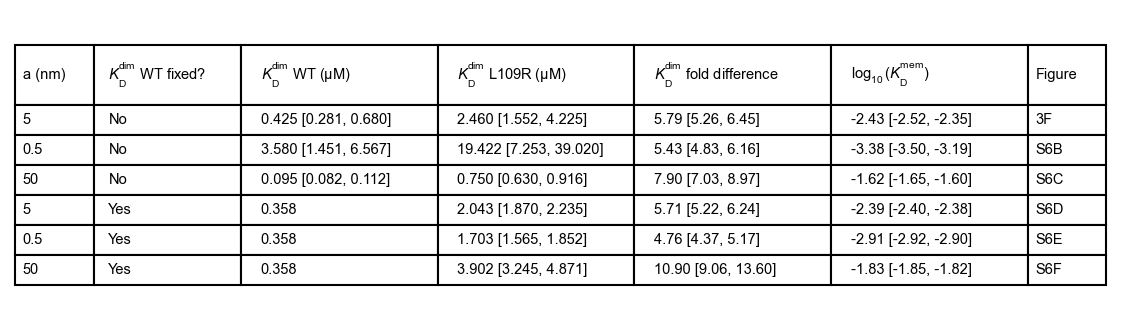

In [6]:
def plot_table(results):
    fig, ax = plt.subplots()
    fontsize = 7
    cell_text = []
    for row in range(len(results)):
        cell_text.append(results.iloc[row])
    widths = np.array([0.08, 0.15, 0.2, 0.2, 0.2, 0.2, 0.08])
    tab = ax.table(
        cellText=cell_text,
        colLabels=results.columns,
        loc="center",
        colWidths=widths / sum(widths),
        cellLoc="left",
        colLoc="left",
    )
    tab.auto_set_font_size(False)
    cellDict = tab.get_celld()
    for i in range(0, len(results.columns)):
        cellDict[(0, i)].set_height(0.2)
        for j in range(1, len(cell_text) + 1):
            cellDict[(j, i)].set_height(0.1)
    tab.set_fontsize(fontsize)
    ax.axis("off")
    fig.set_size_inches(7.5, 2)
    fig.subplots_adjust(left=0.01, right=0.98, bottom=0, top=1)
    return fig


fig = plot_table(res)
fig.savefig("Figs/parameters.png", dpi=600, transparent=True)
fig.savefig("Figs/parameters.pdf", transparent=True)